# Simple LSTM - Tesla

#### Import Libraries

In [82]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

### Data Preparation

#### Download Data from yFinance

In [83]:
# download dataset
ticker = 'TSLA'

df = yf.download(ticker, period='max')

df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29 00:00:00+00:00,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30 00:00:00+00:00,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01 00:00:00+00:00,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02 00:00:00+00:00,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06 00:00:00+00:00,1.074000,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...,...
2024-12-04 00:00:00+00:00,357.929993,357.929993,358.100006,348.600006,353.000000,50810900
2024-12-05 00:00:00+00:00,369.489990,369.489990,375.429993,359.500000,359.869995,81403600


#### Reformat the Data

In [84]:
# flatten the columns to remove multi-level structure
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# reset the index
df.reset_index(inplace=True)

# remove the name 'price' from the columns
df.columns.name = None

df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-06-29 00:00:00+00:00,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30 00:00:00+00:00,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01 00:00:00+00:00,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02 00:00:00+00:00,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06 00:00:00+00:00,1.074000,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...,...,...
3633,2024-12-04 00:00:00+00:00,357.929993,357.929993,358.100006,348.600006,353.000000,50810900
3634,2024-12-05 00:00:00+00:00,369.489990,369.489990,375.429993,359.500000,359.869995,81403600
3635,2024-12-06 00:00:00+00:00,389.220001,389.220001,389.489990,370.799988,377.420013,81455800
3636,2024-12-09 00:00:00+00:00,389.790009,389.790009,404.799988,378.010010,397.609985,96359200


In [85]:
df = df[['Date', 'Close']]  # choose close as the target to predict

df

,Date,Close
0,2010-06-29 00:00:00+00:00,1.592667
1,2010-06-30 00:00:00+00:00,1.588667
2,2010-07-01 00:00:00+00:00,1.464000
3,2010-07-02 00:00:00+00:00,1.280000
4,2010-07-06 00:00:00+00:00,1.074000
...,...,...
3633,2024-12-04 00:00:00+00:00,357.929993
3634,2024-12-05 00:00:00+00:00,369.489990
3635,2024-12-06 00:00:00+00:00,389.220001
3636,2024-12-09 00:00:00+00:00,389.790009


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638 entries, 0 to 3637
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    3638 non-null   datetime64[ns, UTC]
 1   Close   3638 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 57.0 KB


In [87]:
# remove timezone
df.loc[:, 'Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

/var/folders/cl/x4g3r0nj7qvb_h2ft5kt0zhw0000gn/T/ipykernel_72358/1532410079.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2010-06-29 00:00:00', '2010-06-30 00:00:00', '2010-07-01 00:00:00',
 '2010-07-02 00:00:00', '2010-07-06 00:00:00', '2010-07-07 00:00:00',
 '2010-07-08 00:00:00', '2010-07-09 00:00:00', '2010-07-12 00:00:00',
 '2010-07-13 00:00:00',
 ...
 '2024-11-26 00:00:00', '2024-11-27 00:00:00', '2024-11-29 00:00:00',
 '2024-12-02 00:00:00', '2024-12-03 00:00:00', '2024-12-04 00:00:00',
 '2024-12-05 00:00:00', '2024-12-06 00:00:00', '2024-12-09 00:00:00',
 '2024-12-10 00:00:00']
Length: 3638, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df.loc[:, 'Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638 entries, 0 to 3637
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3638 non-null   datetime64[ns]
 1   Close   3638 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.0 KB


In [89]:
df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3633,2024-12-04,357.929993
3634,2024-12-05,369.489990
3635,2024-12-06,389.220001
3636,2024-12-09,389.790009


#### EDA

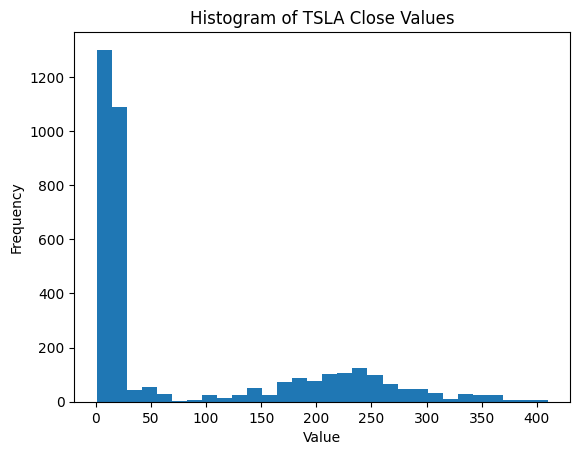

In [90]:
# plot histogram of close values
plt.hist(df['Close'], bins=30)
plt.title(f'Histogram of {ticker} Close Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


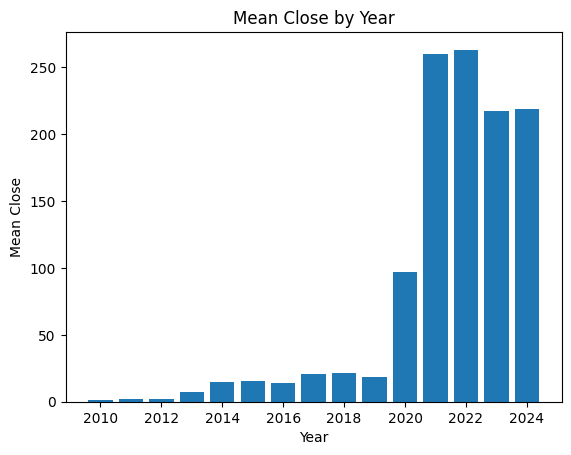

In [91]:
# plot histogram of mean close values by year
df_year = df.copy()
df_year.loc[:, 'year'] = df_year['Date'].dt.year

# group by year and calculate mean
data_grouped = df_year.drop('Date', axis=1).groupby('year').mean()

plt.bar(data_grouped.index, data_grouped['Close'])
plt.title('Mean Close by Year')
plt.xlabel('Year')
plt.ylabel('Mean Close')
plt.show()

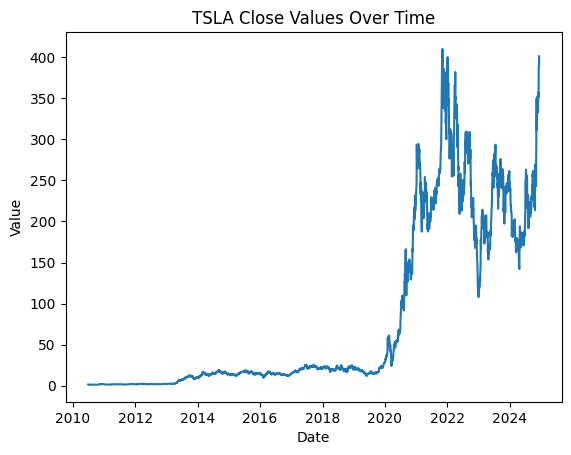

In [92]:
# plot the close values over time
plt.plot(df['Date'], df['Close'])
plt.title(f'{ticker} Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Time Period Used: Max

### Linear Regression

In [93]:
# set max date as end_date
end_date_1 = df['Date'].max()

# set min date as start_date
start_date_1 = df['Date'].iloc[3]  # get the 4th value (necessary for lstm)

start_date_1, end_date_1

(Timestamp('2010-07-02 00:00:00'), Timestamp('2024-12-10 00:00:00'))

In [94]:
# drop rows not in start and end range
df_lr = df[(df['Date'] >= start_date_1) & (df['Date'] <= end_date_1)]

df_lr

,Date,Close
3,2010-07-02,1.280000
4,2010-07-06,1.074000
5,2010-07-07,1.053333
6,2010-07-08,1.164000
7,2010-07-09,1.160000
...,...,...
3633,2024-12-04,357.929993
3634,2024-12-05,369.489990
3635,2024-12-06,389.220001
3636,2024-12-09,389.790009


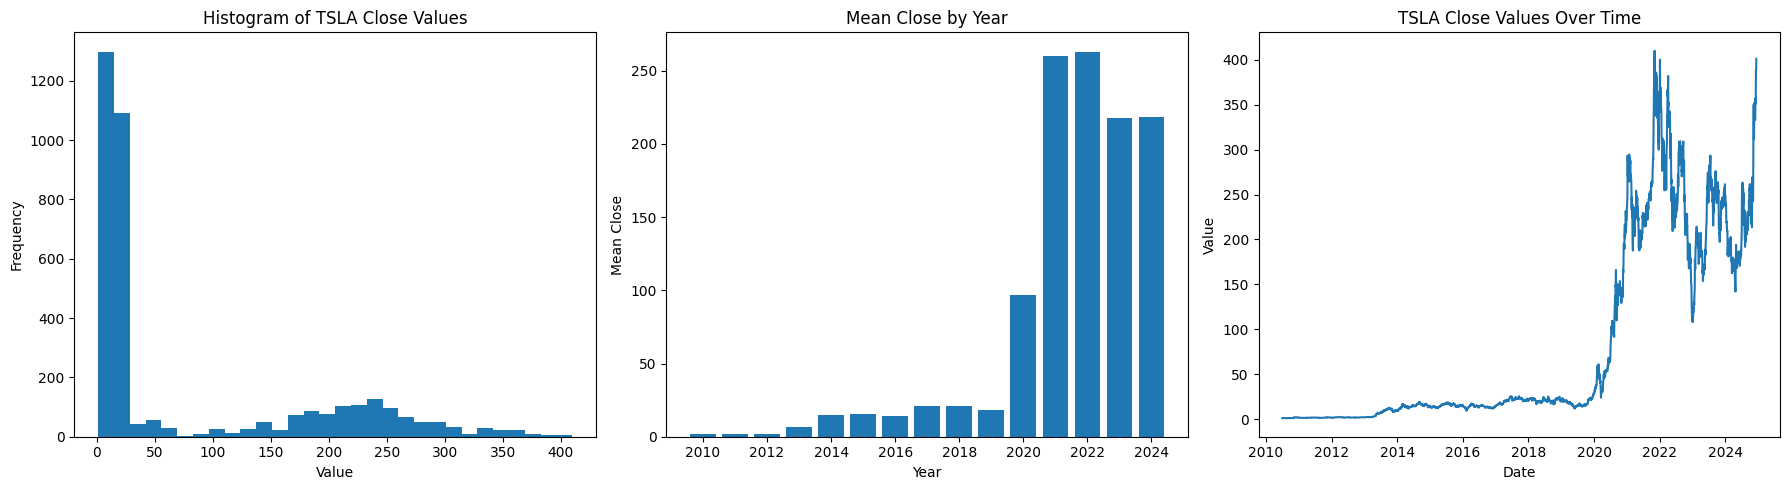

In [95]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['Close'], bins=30)
axs[0].set_title(f'Histogram of {ticker} Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year['Date'].dt.year

# group by year and calculate mean
data_grouped = df_year.drop('Date', axis=1).groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['Close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr['Date'], df_lr['Close'])
axs[2].set_title(f'{ticker} Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [96]:
# split the data into train and test sets
X = df_lr['Date']
Y = df_lr['Close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.1, random_state=123)

In [97]:
# reshape into 2D arrays and convert to days
X_train_lr = (X_train_lr - X_train_lr.min()).dt.days.values.reshape(-1, 1)
X_test_lr = (X_test_lr - X_test_lr.min()).dt.days.values.reshape(-1, 1)

In [98]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(3271, 1)
(364, 1)
(3271,)
(364,)


In [99]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [100]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [101]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

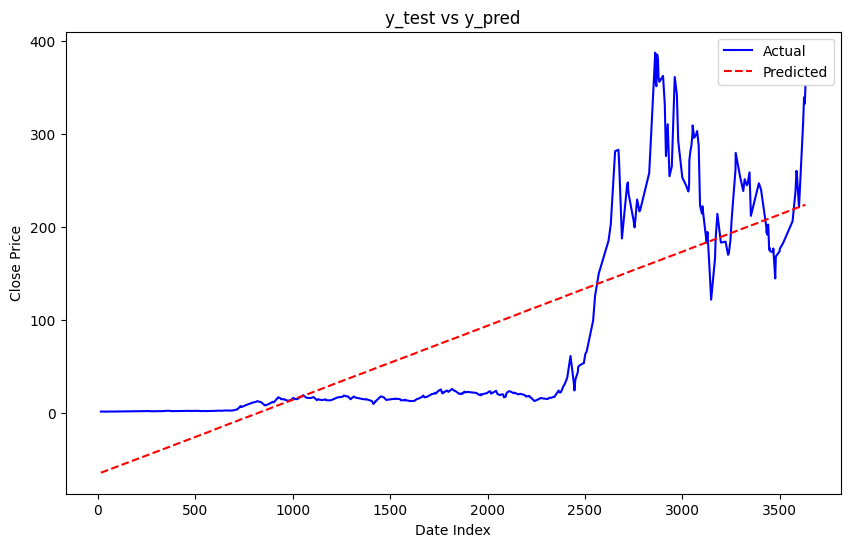

In [102]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [103]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.639171,0.619801
MSE,3984.223793,4559.376192


### LSTM

In [104]:
df_lstm = df.copy()

# make date the index
df_lstm.index = df_lstm.pop('Date')

df_lstm

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-04,357.929993
2024-12-05,369.489990
2024-12-06,389.220001


In [105]:
# define function to convert string to datetime
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [106]:
# define function to create lstm data structure
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [107]:
# convert start and end date to strings
end_date_str = end_date_1.strftime('%Y-%m-%d')
start_date_str = start_date_1.strftime('%Y-%m-%d')

In [108]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_lstm, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-07-02,1.592667,1.588667,1.464000,1.280000
1,2010-07-06,1.588667,1.464000,1.280000,1.074000
2,2010-07-07,1.464000,1.280000,1.074000,1.053333
3,2010-07-08,1.280000,1.074000,1.053333,1.164000
4,2010-07-09,1.074000,1.053333,1.164000,1.160000
...,...,...,...,...,...
3630,2024-12-04,345.160004,357.089996,351.420013,357.929993
3631,2024-12-05,357.089996,351.420013,357.929993,369.489990
3632,2024-12-06,351.420013,357.929993,369.489990,389.220001
3633,2024-12-09,357.929993,369.489990,389.220001,389.790009


Target is the close value for the target date. Target-3,2,1 are the three previous close values that came before the target date.

In [109]:
# select target and feature variables
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  # separate the dates
  dates = df_as_np[:, 0]

  # feature
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))  # reshape for lstm input

  # target
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((3635,), (3635, 3, 1), (3635,))

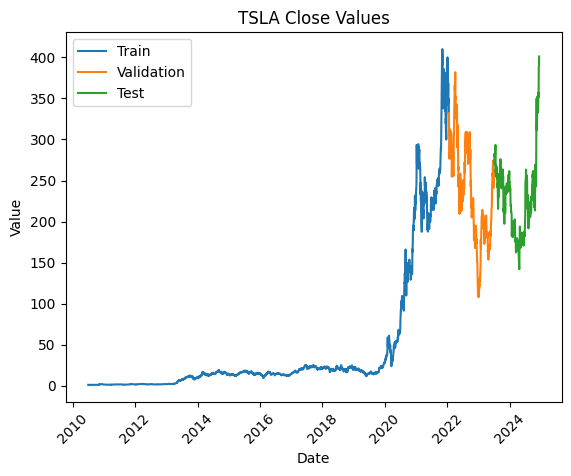

In [110]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'{ticker} Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7980.8857 - mean_absolute_error: 39.2633 - val_loss: 48203.8359 - val_mean_absolute_error: 211.2688
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 6932.8960 - mean_absolute_error: 30.0468 - val_loss: 40340.6016 - val_mean_absolute_error: 191.7641
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 5033.8838 - mean_absolute_error: 24.7205 - val_loss: 33965.9414 - val_mean_absolute_error: 174.3526
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 4303.4893 - mean_absolute_error: 22.6313 - val_loss: 28603.9238 - val_mean_absolute_error: 158.2312
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 3961.7004 - mean_absolute_error: 21.7304 - val_loss: 23906.8926 - val_mean_absolute_error: 142.6228
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 2878.5923 - mean_absolute_error: 17.3380 - val_loss: 19543.0000 - val_mean_absolute_error: 126.4282
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6

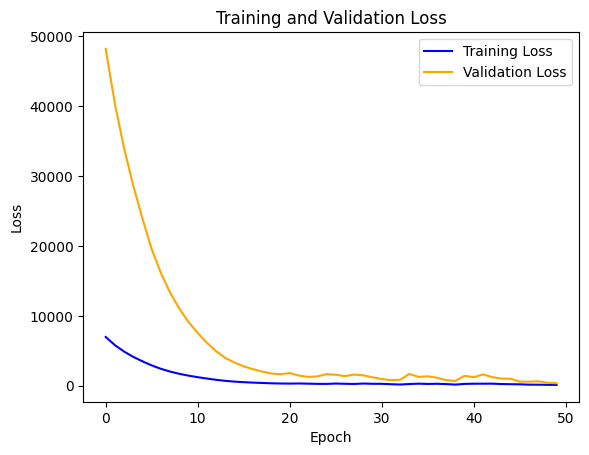

In [111]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7638.0288 - mean_absolute_error: 41.1508 - val_loss: 50476.2461 - val_mean_absolute_error: 216.5424
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 5603.7256 - mean_absolute_error: 28.8258 - val_loss: 9909.8037 - val_mean_absolute_error: 82.7833
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 885.0853 - mean_absolute_error: 8.3342 - val_loss: 596.7646 - val_mean_absolute_error: 16.3587
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 124.6300 - mean_absolute_error: 3.2448 - val_loss: 845.6560 - val_mean_absolute_error: 26.3153
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 57.3787 - mean_absolute_error: 2.8039 - val_loss: 326.7607 - val_mean_absolute_error: 15.3420
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 25.8479 - mean_absolute_error: 2.0584 - val_loss: 352.3646 - val_mean_absolute_error: 14.7379
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 29.764

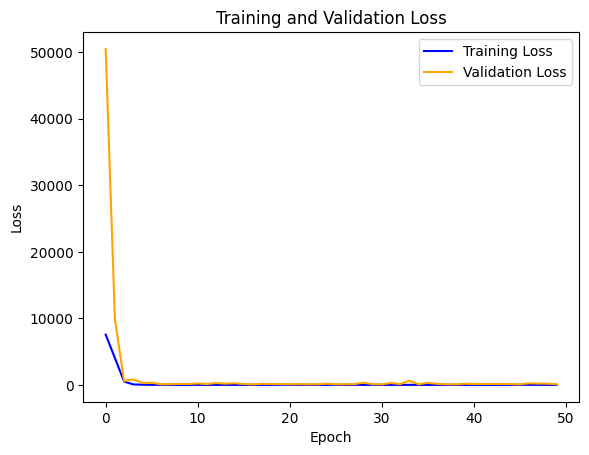

In [112]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [114]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


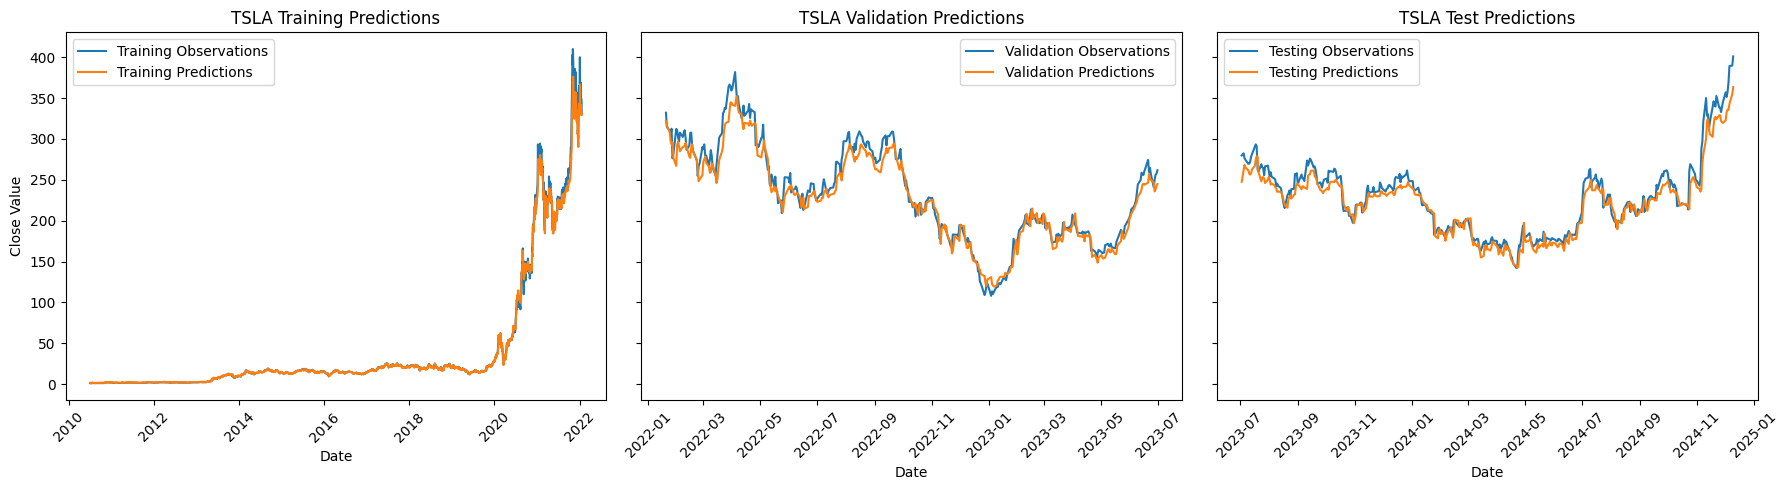

In [115]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title(f'{ticker} Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title(f'{ticker} Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title(f'{ticker} Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

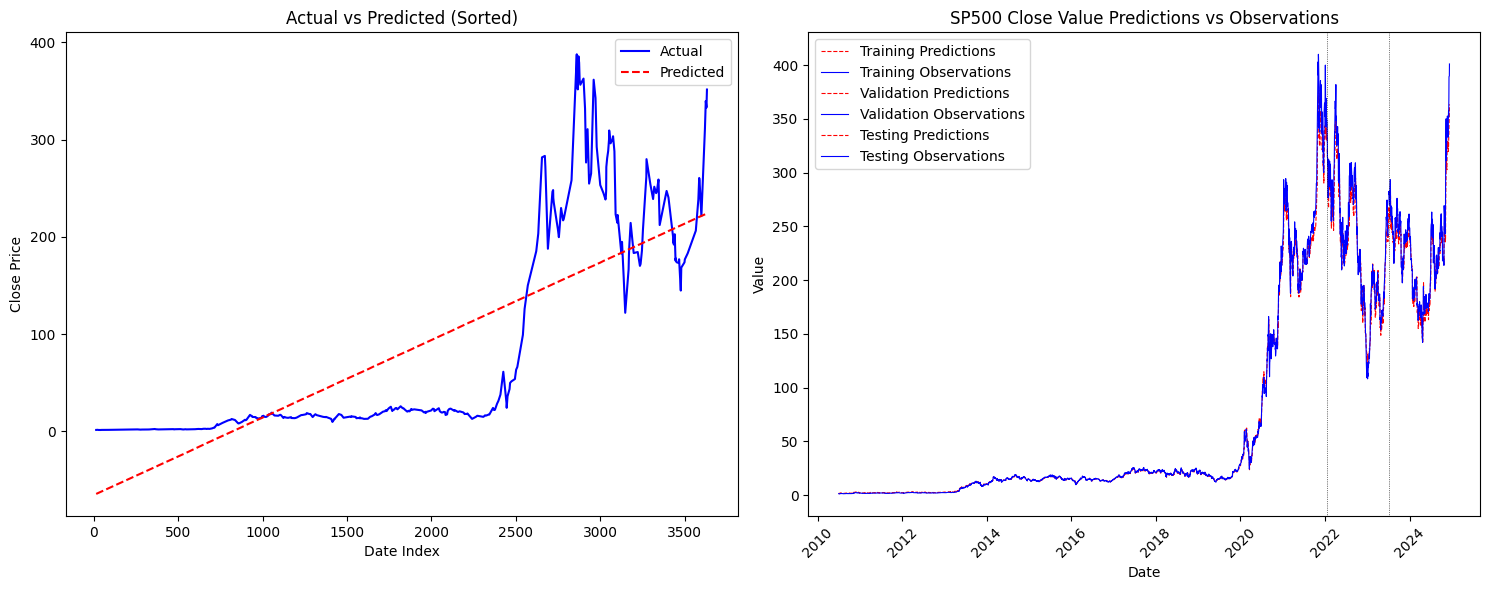

In [116]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Actual vs Predicted (Sorted)')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title(f'SP500 Close Value Predictions vs Observations')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [117]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,3984.223793,4559.376192
LSTM,18.692307,157.997055


## Time Period Used: 2 Years

### Linear Regression

In [118]:
# set max date as end_date
end_date_2 = df['Date'].max()

# calculate start date
tentative_start_date_2 = end_date_2 - pd.DateOffset(years=2)  # select last 2 years

# find the closest valid start date
start_date_2 = df['Date'][df['Date'] >= tentative_start_date_2].min()

start_date_2, end_date_2

(Timestamp('2022-12-12 00:00:00'), Timestamp('2024-12-10 00:00:00'))

In [119]:
# drop rows not in start and end range
df_lr = df[(df['Date'] >= start_date_2) & (df['Date'] <= end_date_2)]

df_lr

,Date,Close
3136,2022-12-12,167.820007
3137,2022-12-13,160.949997
3138,2022-12-14,156.800003
3139,2022-12-15,157.669998
3140,2022-12-16,150.229996
...,...,...
3633,2024-12-04,357.929993
3634,2024-12-05,369.489990
3635,2024-12-06,389.220001
3636,2024-12-09,389.790009


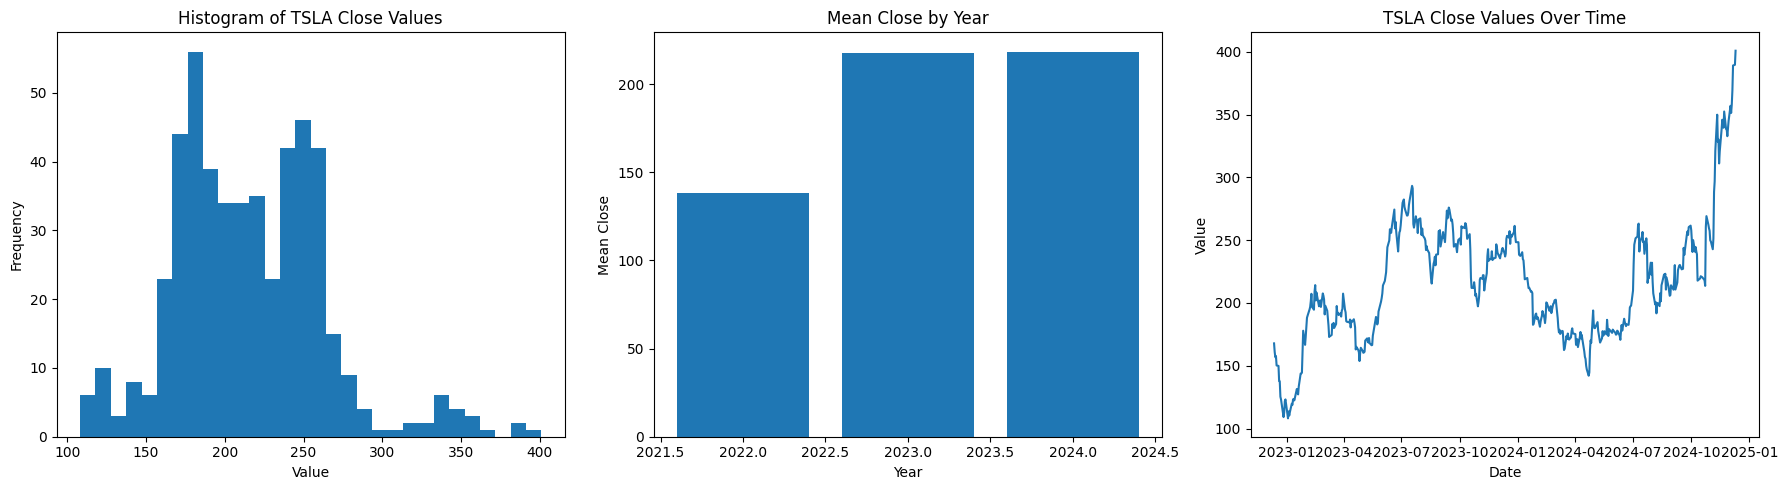

In [120]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['Close'], bins=30)
axs[0].set_title(f'Histogram of {ticker} Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year['Date'].dt.year

# group by year and calculate mean
data_grouped = df_year.drop('Date', axis=1).groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['Close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr['Date'], df_lr['Close'])
axs[2].set_title(f'{ticker} Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [121]:
# split the data into train and test sets
X = np.array(df_lr.index).reshape(-1,1)
Y = df_lr['Close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.1, random_state=123)

In [122]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(451, 1)
(51, 1)
(451,)
(51,)


In [123]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [124]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [125]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

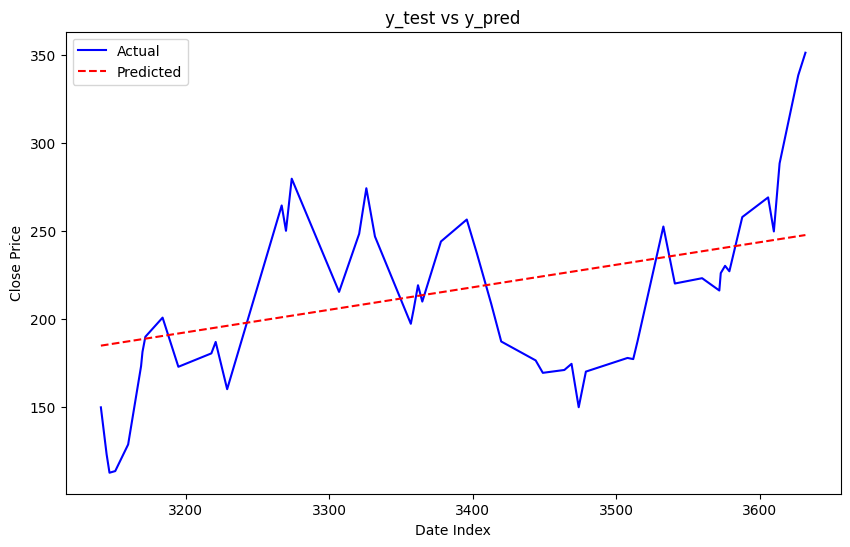

In [126]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [127]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.148916,0.260768
MSE,1929.251592,1917.893714


### LSTM

In [128]:
df_lstm = df.copy()

# make date the index
df_lstm.index = df_lstm.pop('Date')

df_lstm

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-04,357.929993
2024-12-05,369.489990
2024-12-06,389.220001


In [129]:
# convert start and end date to strings
end_date_str = end_date_2.strftime('%Y-%m-%d')
start_date_str = start_date_2.strftime('%Y-%m-%d')

In [130]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_lstm, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-12-12,174.039993,173.440002,179.050003,167.820007
1,2022-12-13,173.440002,179.050003,167.820007,160.949997
2,2022-12-14,179.050003,167.820007,160.949997,156.800003
3,2022-12-15,167.820007,160.949997,156.800003,157.669998
4,2022-12-16,160.949997,156.800003,157.669998,150.229996
...,...,...,...,...,...
497,2024-12-04,345.160004,357.089996,351.420013,357.929993
498,2024-12-05,357.089996,351.420013,357.929993,369.489990
499,2024-12-06,351.420013,357.929993,369.489990,389.220001
500,2024-12-09,357.929993,369.489990,389.220001,389.790009


In [131]:
# select target and feature variables
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((502,), (502, 3, 1), (502,))

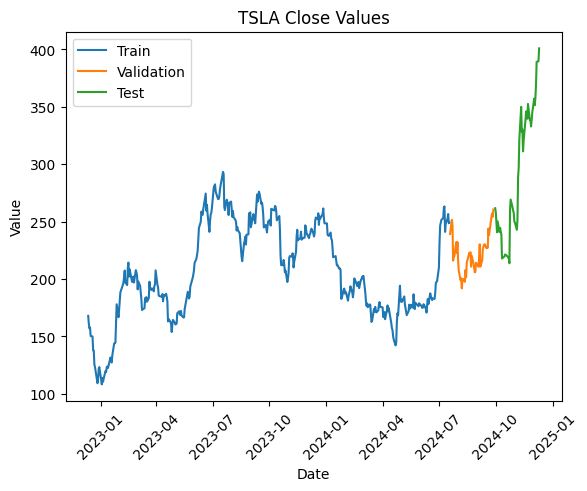

In [132]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'{ticker} Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42395.5703 - mean_absolute_error: 201.7547 - val_loss: 48348.5000 - val_mean_absolute_error: 219.2280
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41835.5273 - mean_absolute_error: 200.2735 - val_loss: 47256.6133 - val_mean_absolute_error: 216.7235
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42165.1758 - mean_absolute_error: 200.8521 - val_loss: 46077.0703 - val_mean_absolute_error: 213.9847
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39608.8086 - mean_absolute_error: 194.7751 - val_loss: 44774.3711 - val_mean_absolute_error: 210.9191
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39242.3477 - mean_absolute_error: 193.9173 - val_loss: 43583.4688 - val_mean_absolute_error: 208.0768
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38132.2109 - mean_absolute_error: 190.8826 - val_loss: 42445.8203 - val_mean_absolute_error: 205.3248
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

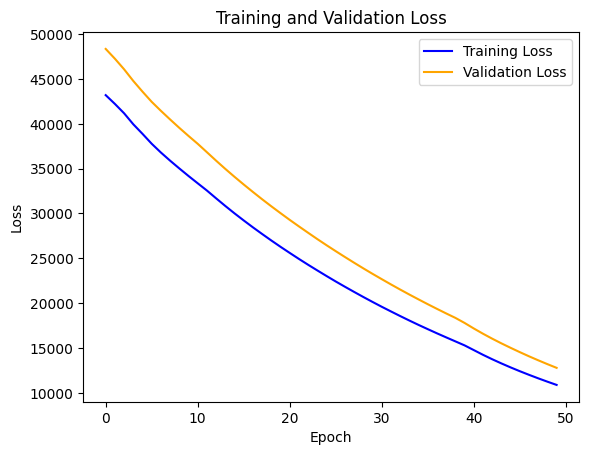

In [133]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44457.7266 - mean_absolute_error: 206.8806 - val_loss: 49020.7695 - val_mean_absolute_error: 220.7558
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43140.8164 - mean_absolute_error: 203.7453 - val_loss: 48144.6797 - val_mean_absolute_error: 218.7622
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42007.5938 - mean_absolute_error: 200.7984 - val_loss: 46995.9883 - val_mean_absolute_error: 216.1210
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41294.9492 - mean_absolute_error: 198.9447 - val_loss: 45602.2812 - val_mean_absolute_error: 212.8684
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39168.0039 - mean_absolute_error: 193.6019 - val_loss: 43165.5508 - val_mean_absolute_error: 207.0651
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36787.8242 - mean_absolute_error: 187.3949 - val_loss: 39947.1094 - val_mean_absolute_error: 199.1389
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

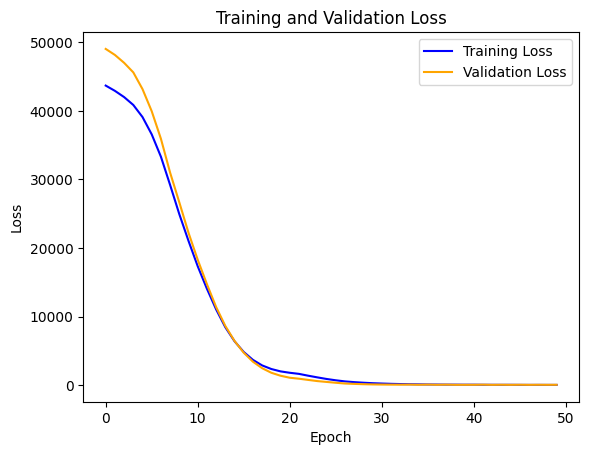

In [135]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 43837.9727 - mean_absolute_error: 205.5992 - val_loss: 49513.8594 - val_mean_absolute_error: 221.8699
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43506.9219 - mean_absolute_error: 204.6707 - val_loss: 49213.3086 - val_mean_absolute_error: 221.1920
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43153.6602 - mean_absolute_error: 203.2907 - val_loss: 48848.1016 - val_mean_absolute_error: 220.3641
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43229.2930 - mean_absolute_error: 203.7864 - val_loss: 48248.3086 - val_mean_absolute_error: 218.9984
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42500.3594 - mean_absolute_error: 202.1248 - val_loss: 47016.7461 - val_mean_absolute_error: 216.1684
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41187.5547 - mean_absolute_error: 198.6545 - val_loss: 45289.5469 - val_mean_absolute_error: 212.1370
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

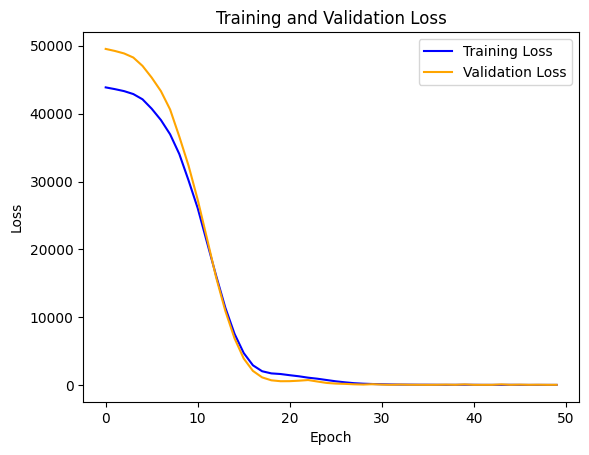

In [134]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [136]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


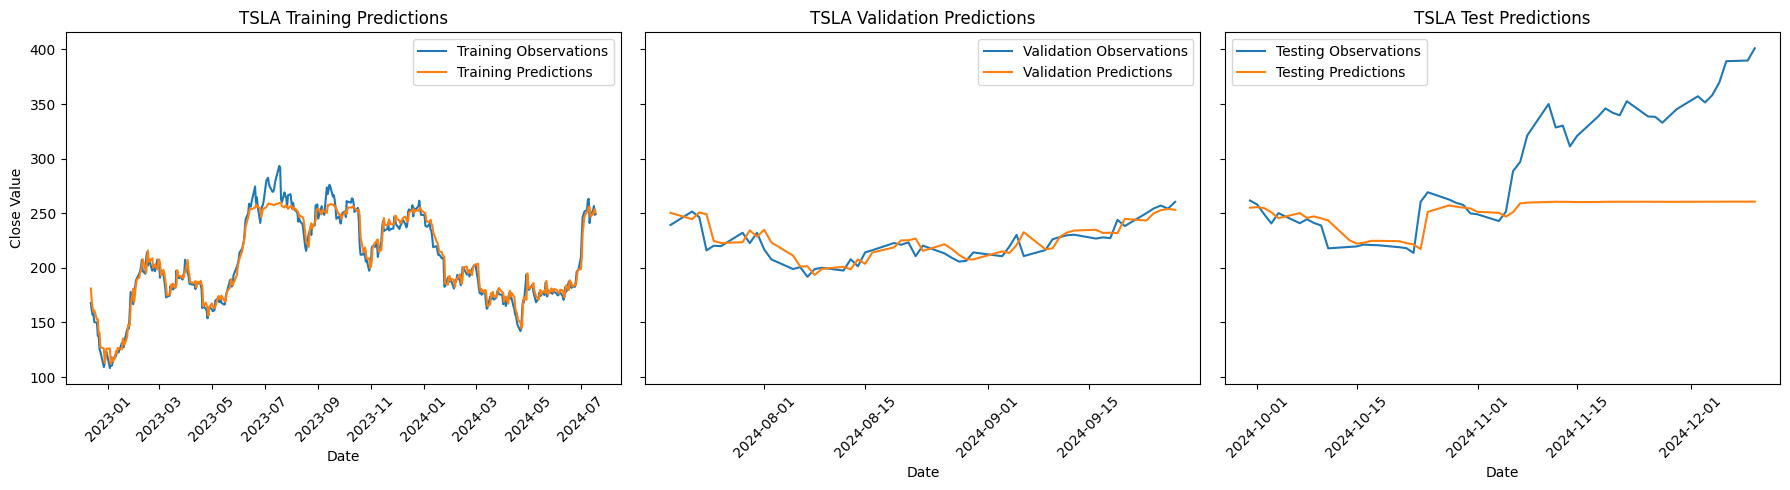

In [137]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title(f'{ticker} Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title(f'{ticker} Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title(f'{ticker} Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

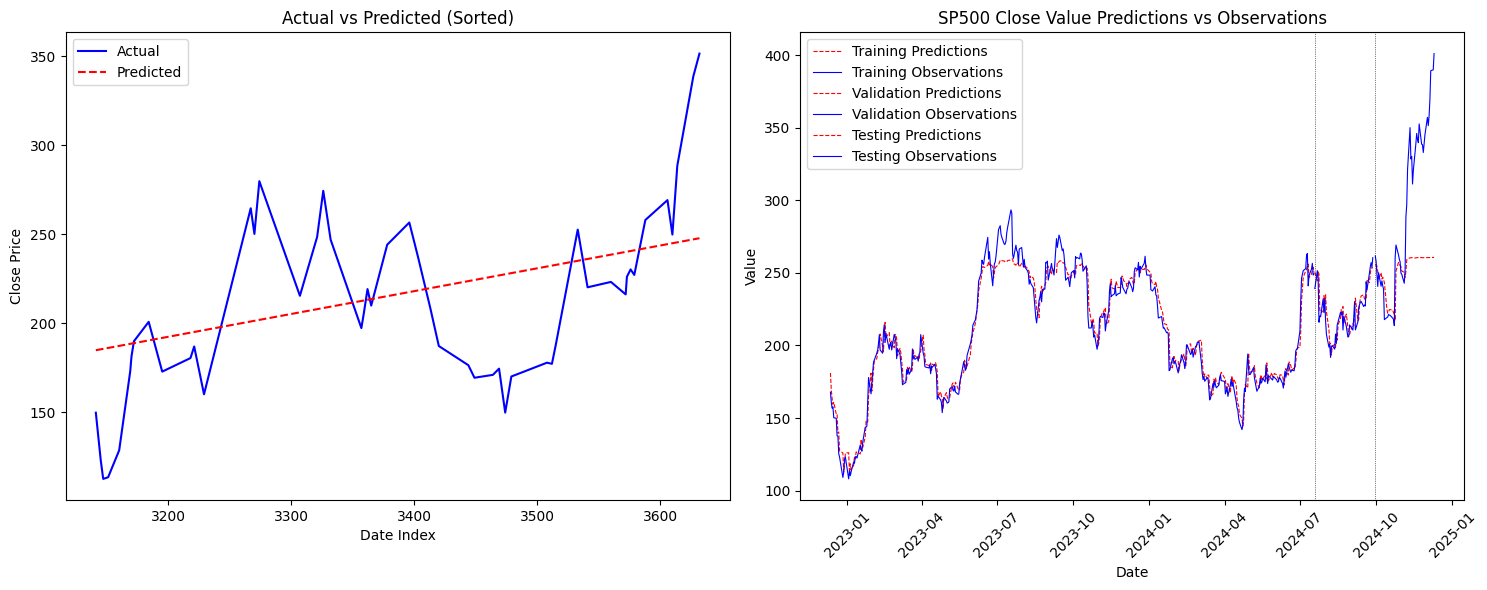

In [138]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Actual vs Predicted (Sorted)')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title(f'SP500 Close Value Predictions vs Observations')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [139]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,1929.251592,1917.893714
LSTM,67.511055,3633.377197


## Time Period Used: 3 Years

### Linear Regression

In [140]:
# set max date as end_date
end_date_3 = df['Date'].max()

# calculate start date
tentative_start_date_3 = end_date_3 - pd.DateOffset(years=3)  # select last 3 years

# find the closest valid start date
start_date_3 = df['Date'][df['Date'] >= tentative_start_date_3].min()

start_date_3, end_date_3

(Timestamp('2021-12-10 00:00:00'), Timestamp('2024-12-10 00:00:00'))

In [141]:
# drop rows not in start and end range
df_lr = df[(df['Date'] >= start_date_3) & (df['Date'] <= end_date_3)]

df_lr

,Date,Close
2884,2021-12-10,339.010010
2885,2021-12-13,322.136658
2886,2021-12-14,319.503326
2887,2021-12-15,325.329987
2888,2021-12-16,308.973328
...,...,...
3633,2024-12-04,357.929993
3634,2024-12-05,369.489990
3635,2024-12-06,389.220001
3636,2024-12-09,389.790009


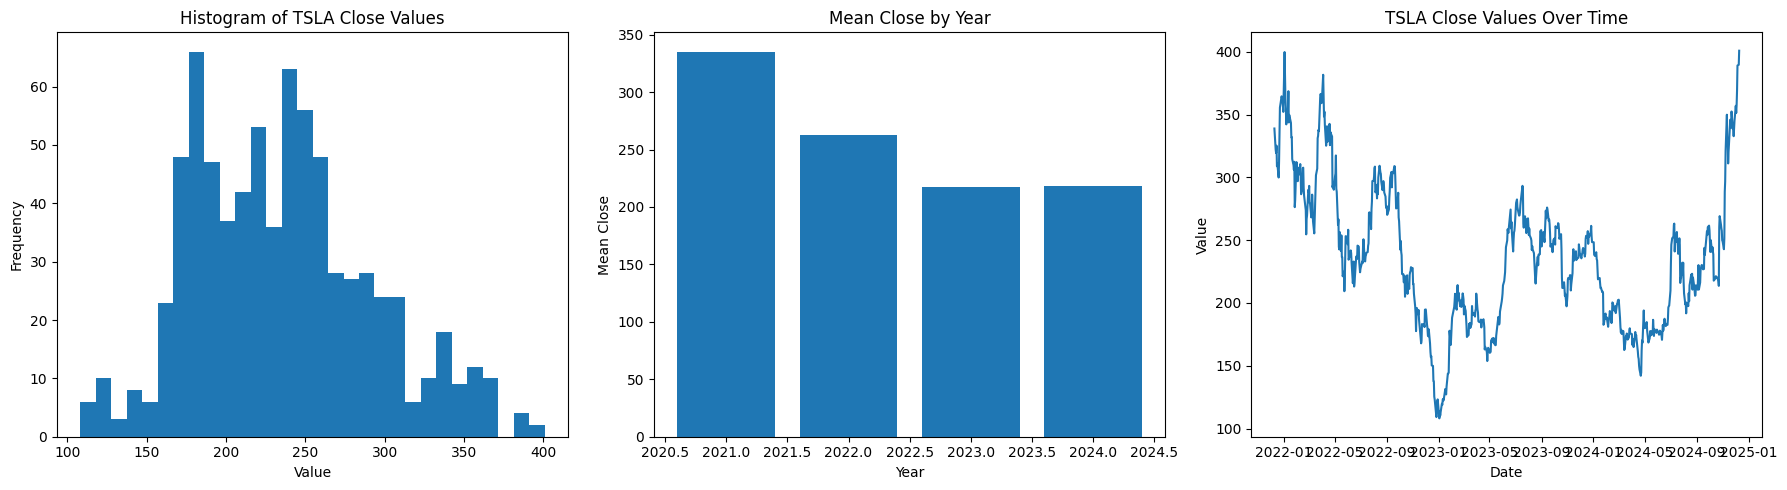

In [142]:
# create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

# plot histogram of close values
axs[0].hist(df_lr['Close'], bins=30)
axs[0].set_title(f'Histogram of {ticker} Close Values')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# plot histogram of mean close values by year
df_year = df_lr.copy()
df_year.loc[:, 'year'] = df_year['Date'].dt.year

# group by year and calculate mean
data_grouped = df_year.drop('Date', axis=1).groupby('year').mean()

axs[1].bar(data_grouped.index, data_grouped['Close'])
axs[1].set_title('Mean Close by Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean Close')

# plot the close values over time
axs[2].plot(df_lr['Date'], df_lr['Close'])
axs[2].set_title(f'{ticker} Close Values Over Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [143]:
# split the data into train and test sets
X = np.array(df_lr.index).reshape(-1,1)
Y = df_lr['Close']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, Y, test_size=0.1, random_state=123)

In [144]:
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(678, 1)
(76, 1)
(678,)
(76,)


In [145]:
# create linear model
lm = LinearRegression()
lm.fit(X_train_lr, y_train_lr)

LinearRegression()

In [146]:
# predict using the trained model
y_pred_lr = lm.predict(X_test_lr)

In [147]:
# sort index to maintain alignment with predictions
sorted_indices = np.argsort(X_test_lr.flatten())  # get sorted indices
y_test_sorted = y_test_lr.iloc[sorted_indices]    # sort test data
y_pred_sorted = y_pred_lr[sorted_indices]         # sort predictions

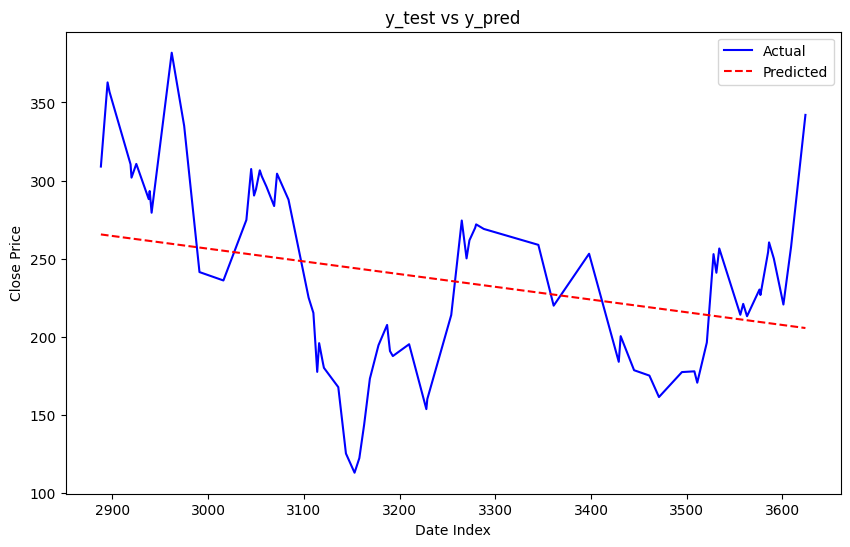

In [148]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')

plt.title('y_test vs y_pred')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [149]:
# calculate scores and store them in a dictionary
evaluation_scores = {
    'Metric': ['r2_score', 'MSE'],
    'Train': [
        r2_score(y_train_lr, lm.predict(X_train_lr)),
        mse(y_train_lr, lm.predict(X_train_lr))
    ],
    'Test': [
        r2_score(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test_lr, lm.predict(X_test_lr))
    ]
}

# convert the dictionary to a df and print
eval_scores_df = pd.DataFrame(evaluation_scores)
eval_scores_df.style.hide(axis="index")

Metric,Train,Test
r2_score,0.099164,0.135126
MSE,2824.656459,3092.547691


### LSTM

In [150]:
df_lstm = df.copy()

# make date the index
df_lstm.index = df_lstm.pop('Date')

df_lstm

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2024-12-04,357.929993
2024-12-05,369.489990
2024-12-06,389.220001


In [151]:
# convert start and end date to strings
end_date_str = end_date_3.strftime('%Y-%m-%d')
start_date_str = start_date_3.strftime('%Y-%m-%d')

In [152]:
# create lstm data structure
windowed_df = df_to_windowed_df(df_lstm, 
                                start_date_str, 
                                end_date_str, 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-12-10,350.583344,356.320007,334.600006,339.010010
1,2021-12-13,356.320007,334.600006,339.010010,322.136658
2,2021-12-14,334.600006,339.010010,322.136658,319.503326
3,2021-12-15,339.010010,322.136658,319.503326,325.329987
4,2021-12-16,322.136658,319.503326,325.329987,308.973328
...,...,...,...,...,...
749,2024-12-04,345.160004,357.089996,351.420013,357.929993
750,2024-12-05,357.089996,351.420013,357.929993,369.489990
751,2024-12-06,351.420013,357.929993,369.489990,389.220001
752,2024-12-09,357.929993,369.489990,389.220001,389.790009


In [153]:
# select target and feature variables
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((754,), (754, 3, 1), (754,))

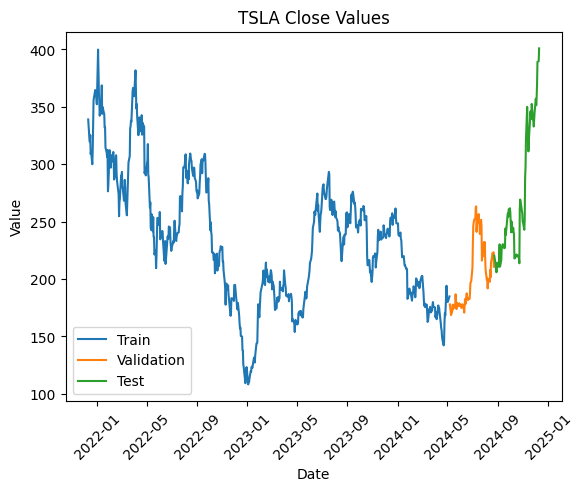

In [154]:
# split into training, validation, and test datasets
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]        # 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]  # 10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]           # 10%

# plot the splits
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.title(f'{ticker} Close Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Train', 'Validation', 'Test'])

plt.xticks(rotation=45)
plt.show()

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 57023.2344 - mean_absolute_error: 232.5629 - val_loss: 40380.7891 - val_mean_absolute_error: 198.9292
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54274.8789 - mean_absolute_error: 225.5011 - val_loss: 38951.2461 - val_mean_absolute_error: 195.3055
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54493.2188 - mean_absolute_error: 226.2630 - val_loss: 37559.7188 - val_mean_absolute_error: 191.7095
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51909.6641 - mean_absolute_error: 220.8076 - val_loss: 36262.4453 - val_mean_absolute_error: 188.2962
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51188.5781 - mean_absolute_error: 218.6022 - val_loss: 35079.6797 - val_mean_absolute_error: 185.1288
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 49896.8984 - mean_absolute_error: 215.8116 - val_loss: 33815.7148 - val_mean_absolute_error: 181.6831
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 

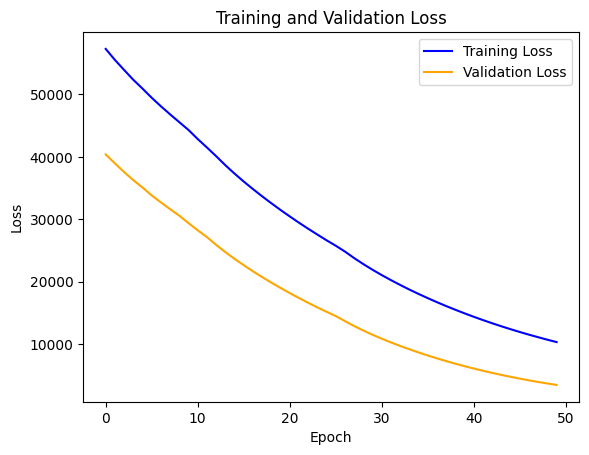

In [155]:
# build model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 58664.5156 - mean_absolute_error: 235.6583 - val_loss: 41910.9219 - val_mean_absolute_error: 202.7411
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57343.4883 - mean_absolute_error: 232.6553 - val_loss: 41497.5742 - val_mean_absolute_error: 201.7184
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57164.7617 - mean_absolute_error: 231.7925 - val_loss: 40602.4648 - val_mean_absolute_error: 199.4851
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56274.7305 - mean_absolute_error: 230.5209 - val_loss: 38803.4570 - val_mean_absolute_error: 194.9213
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52982.0508 - mean_absolute_error: 223.1993 - val_loss: 34777.8945 - val_mean_absolute_error: 184.3089
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47652.4531 - mean_absolute_error: 210.5298 - val_loss: 29072.0332 - val_mean_absolute_error: 168.0820
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s

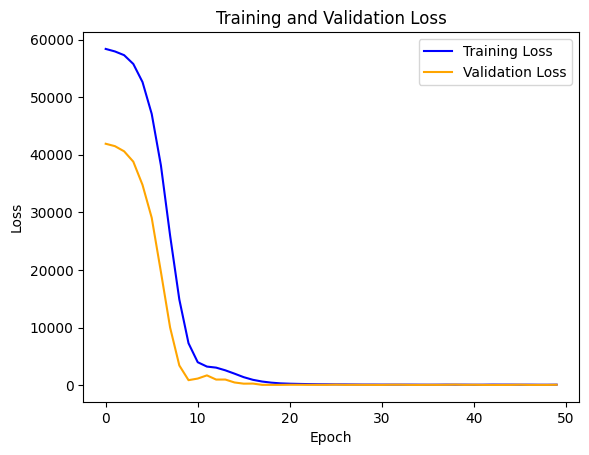

In [156]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 60749.1680 - mean_absolute_error: 239.8796 - val_loss: 41726.5781 - val_mean_absolute_error: 202.2845
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58197.6289 - mean_absolute_error: 234.4076 - val_loss: 40768.7344 - val_mean_absolute_error: 199.9009
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55756.3594 - mean_absolute_error: 229.0015 - val_loss: 39305.6797 - val_mean_absolute_error: 196.2013
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55299.4844 - mean_absolute_error: 228.5631 - val_loss: 36116.2305 - val_mean_absolute_error: 187.8824
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50304.6484 - mean_absolute_error: 216.4987 - val_loss: 30741.6738 - val_mean_absolute_error: 172.9972
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43750.8203 - mean_absolute_error: 201.8490 - val_loss: 25265.9258 - val_mean_absolute_error: 156.3505
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s

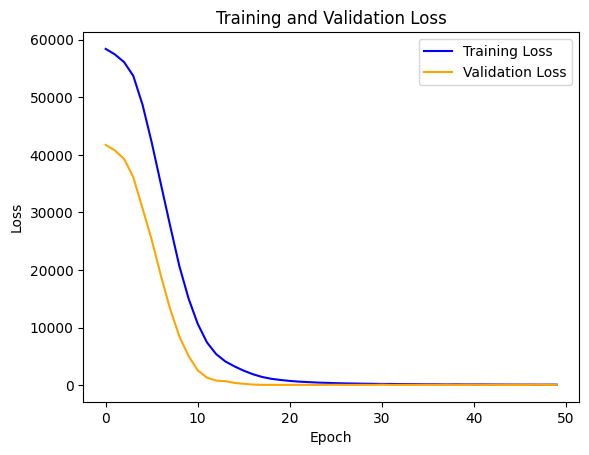

In [157]:
# tune model
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

# compile model. select loss, optimizer, and learning rate
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# fit model and set number of epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

# plot loss per epoch
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [158]:
# get predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


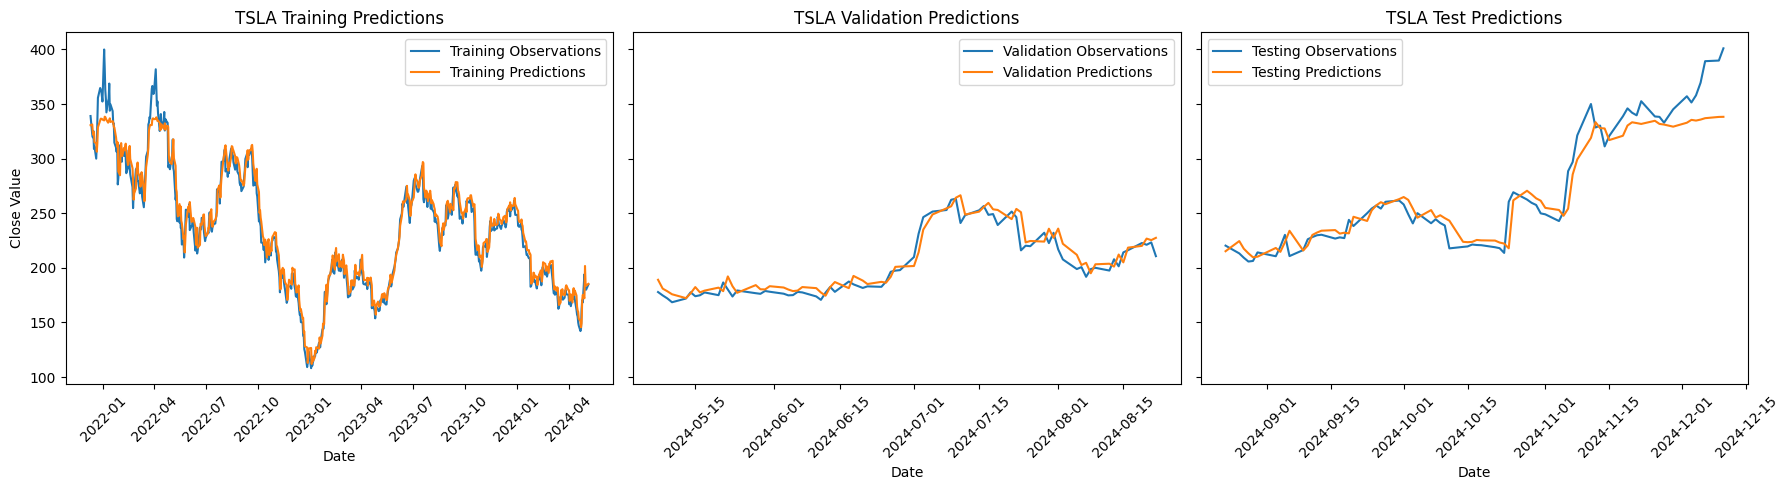

In [159]:
# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Share y-axis for easier comparison

# 1. plot training predictions
axes[0].plot(dates_train, y_train, label='Training Observations')
axes[0].plot(dates_train, train_predictions, label='Training Predictions')
axes[0].set_title(f'{ticker} Training Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Value')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. plot validation predictions
axes[1].plot(dates_val, y_val, label='Validation Observations')
axes[1].plot(dates_val, val_predictions, label='Validation Predictions')
axes[1].set_title(f'{ticker} Validation Predictions')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. plot test predictions
axes[2].plot(dates_test, y_test, label='Testing Observations')
axes[2].plot(dates_test, test_predictions, label='Testing Predictions')
axes[2].set_title(f'{ticker} Test Predictions')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Result

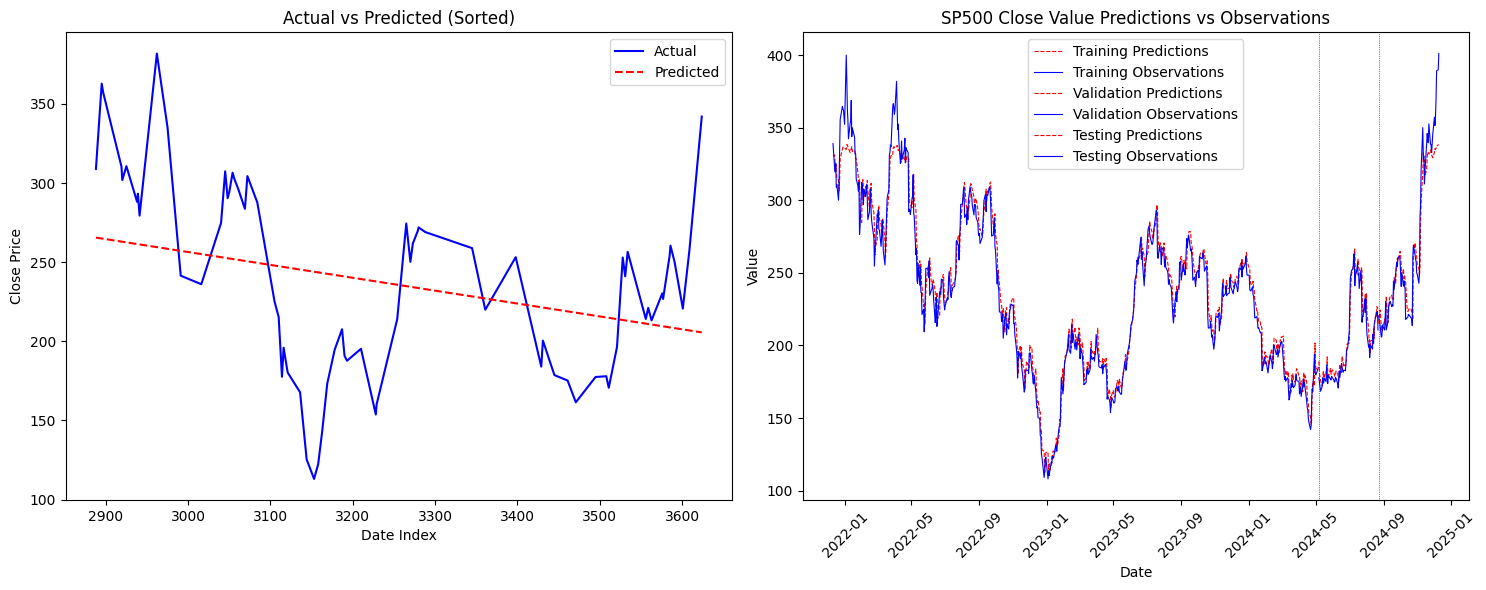

In [160]:
# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. plot actual vs predicted
axes[0].plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue')
axes[0].plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', linestyle='--')
axes[0].set_title('Actual vs Predicted (Sorted)')
axes[0].set_xlabel('Date Index')
axes[0].set_ylabel('Close Price')
axes[0].legend()

# 2. lstm predictions
axes[1].plot(dates_train, train_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_train, y_train, color='blue', linewidth=0.8)

axes[1].plot(dates_val, val_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_val, y_val, color='blue', linewidth=0.8)

axes[1].plot(dates_test, test_predictions, color='red', linestyle='--', linewidth=0.8)
axes[1].plot(dates_test, y_test, color='blue', linewidth=0.8)

# add a vertical dotted line between the training, validation, and test sets
split_train_val = dates_val[0]
split_val_test = dates_test[0]
axes[1].axvline(x=split_train_val, color='black', linestyle=':', linewidth=0.5)
axes[1].axvline(x=split_val_test, color='black', linestyle=':', linewidth=0.5)

axes[1].set_title(f'SP500 Close Value Predictions vs Observations')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])

# Rotate x-axis ticks
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [161]:
# create dictionary to store mse for lr and lstm models
model_scores = {
    'Model': ['Linear Regression', 'LSTM'],
    'Train': [
        mse(y_train_lr, lm.predict(X_train_lr)),
        history.history['loss'][-1]
    ],
    'Test': [
        mse(y_test_lr, lm.predict(X_test_lr)),
        mse(y_test, test_predictions)
    ]
}

# convert the dictionary to a df and print
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.style.hide(axis="index")

Model,Train,Test
Linear Regression,2824.656459,3092.547691
LSTM,114.537445,284.633881
